Credit Card Fraud Analysis
Deep Dive into Anonymized Credit Card Transaction Patterns

Objective: Explore fraud patterns in credit card data to identify risk factors.

Key Questions:
1. What are the V1-V28 features telling us about fraud?
2. How does transaction amount relate to fraud?
3. What are the temporal patterns in credit card fraud?
4. How does this dataset compare to e-commerce fraud patterns?

Dataset: Credit card transactions with anonymized PCA components (V1-V28)
Imbalance: Extremely imbalanced - fraud cases are very rare
Features: Time, Amount, V1-V28 (PCA components), Class (0=legit, 1=fraud)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import json
import os
from pathlib import Path
from datetime import datetime
from scipy import stats
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

warnings.filterwarnings('ignore')

# Custom styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)

# Define directories
BASE_DIR = Path("D:/10 acadamy/fraud-detection-ml-system")
DATA_PROCESSED_DIR = BASE_DIR / "data" / "processed"
OUTPUT_DIR = BASE_DIR / "outputs" / "Data_Analysis_processing"
REPORTS_DIR = OUTPUT_DIR / "reports"
STATISTICS_DIR = OUTPUT_DIR / "statistics"
VISUALIZATIONS_DIR = OUTPUT_DIR / "visualizations"

# Create directories if they don't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
STATISTICS_DIR.mkdir(parents=True, exist_ok=True)
VISUALIZATIONS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# Load credit card data
print("📥 Loading credit card data...")

# Check available files
available_files = os.listdir(DATA_PROCESSED_DIR)
csv_files = [f for f in available_files if f.endswith('.csv')]

# Find credit card files
credit_files = [f for f in csv_files if ('credit' in f.lower() or 'card' in f.lower()) and 'cleaned' in f.lower()]
if credit_files:
    credit_file = DATA_PROCESSED_DIR / max(credit_files)  # Get latest
    try:
        credit_df = pd.read_csv(credit_file)
        print(f"✅ Credit card data loaded: {credit_df.shape[0]:,} transactions, {credit_df.shape[1]} features")
        
        # Check for Class column (different naming conventions)
        class_columns = ['Class', 'class', 'is_fraud', 'fraud', 'target']
        class_col_found = None
        for col in class_columns:
            if col in credit_df.columns:
                class_col_found = col
                break
        
        if class_col_found:
            fraud_cases = credit_df[class_col_found].sum()
            total_cases = len(credit_df)
            fraud_rate = (fraud_cases / total_cases) * 100
            print(f"🎯 Fraud cases: {fraud_cases:,} ({fraud_rate:.4f}%)")
            print(f"📋 Using class column: '{class_col_found}'")
        else:
            print("⚠️ No fraud class column found in data")
            print(f"Available columns: {list(credit_df.columns)}")
            
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        credit_df = pd.DataFrame()
else:
    print("❌ No cleaned credit card data found!")
    print(f"Available files: {csv_files}")
    credit_df = pd.DataFrame()

if not credit_df.empty:
    print("\n🔍 SAMPLE DATA (First 5 rows):")
    display(credit_df.head())
    
    print("\n📋 DATA COLUMNS:")
    for i, col in enumerate(credit_df.columns, 1):
        print(f"  {i:2d}. {col}")
    
    print(f"\n📊 DATA TYPES:")
    print(credit_df.dtypes.value_counts())
    print(f"\n🔍 MISSING VALUES:")
    print(credit_df.isnull().sum().sum())

📥 Loading credit card data...
✅ Credit card data loaded: 283,726 transactions, 31 features
🎯 Fraud cases: 473 (0.1667%)
📋 Using class column: 'Class'

🔍 SAMPLE DATA (First 5 rows):


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



📋 DATA COLUMNS:
   1. Time
   2. V1
   3. V2
   4. V3
   5. V4
   6. V5
   7. V6
   8. V7
   9. V8
  10. V9
  11. V10
  12. V11
  13. V12
  14. V13
  15. V14
  16. V15
  17. V16
  18. V17
  19. V18
  20. V19
  21. V20
  22. V21
  23. V22
  24. V23
  25. V24
  26. V25
  27. V26
  28. V27
  29. V28
  30. Amount
  31. Class

📊 DATA TYPES:
float64    30
int64       1
Name: count, dtype: int64

🔍 MISSING VALUES:
0



⚠️ EXTREME CLASS IMBALANCE ANALYSIS

📊 BASIC STATISTICS:
  • Total transactions: 283,726
  • Legitimate transactions: 283,253 (99.83%)
  • Fraud transactions: 473 (0.1667%)
  • Imbalance ratio: 283,253:473 (599:1)


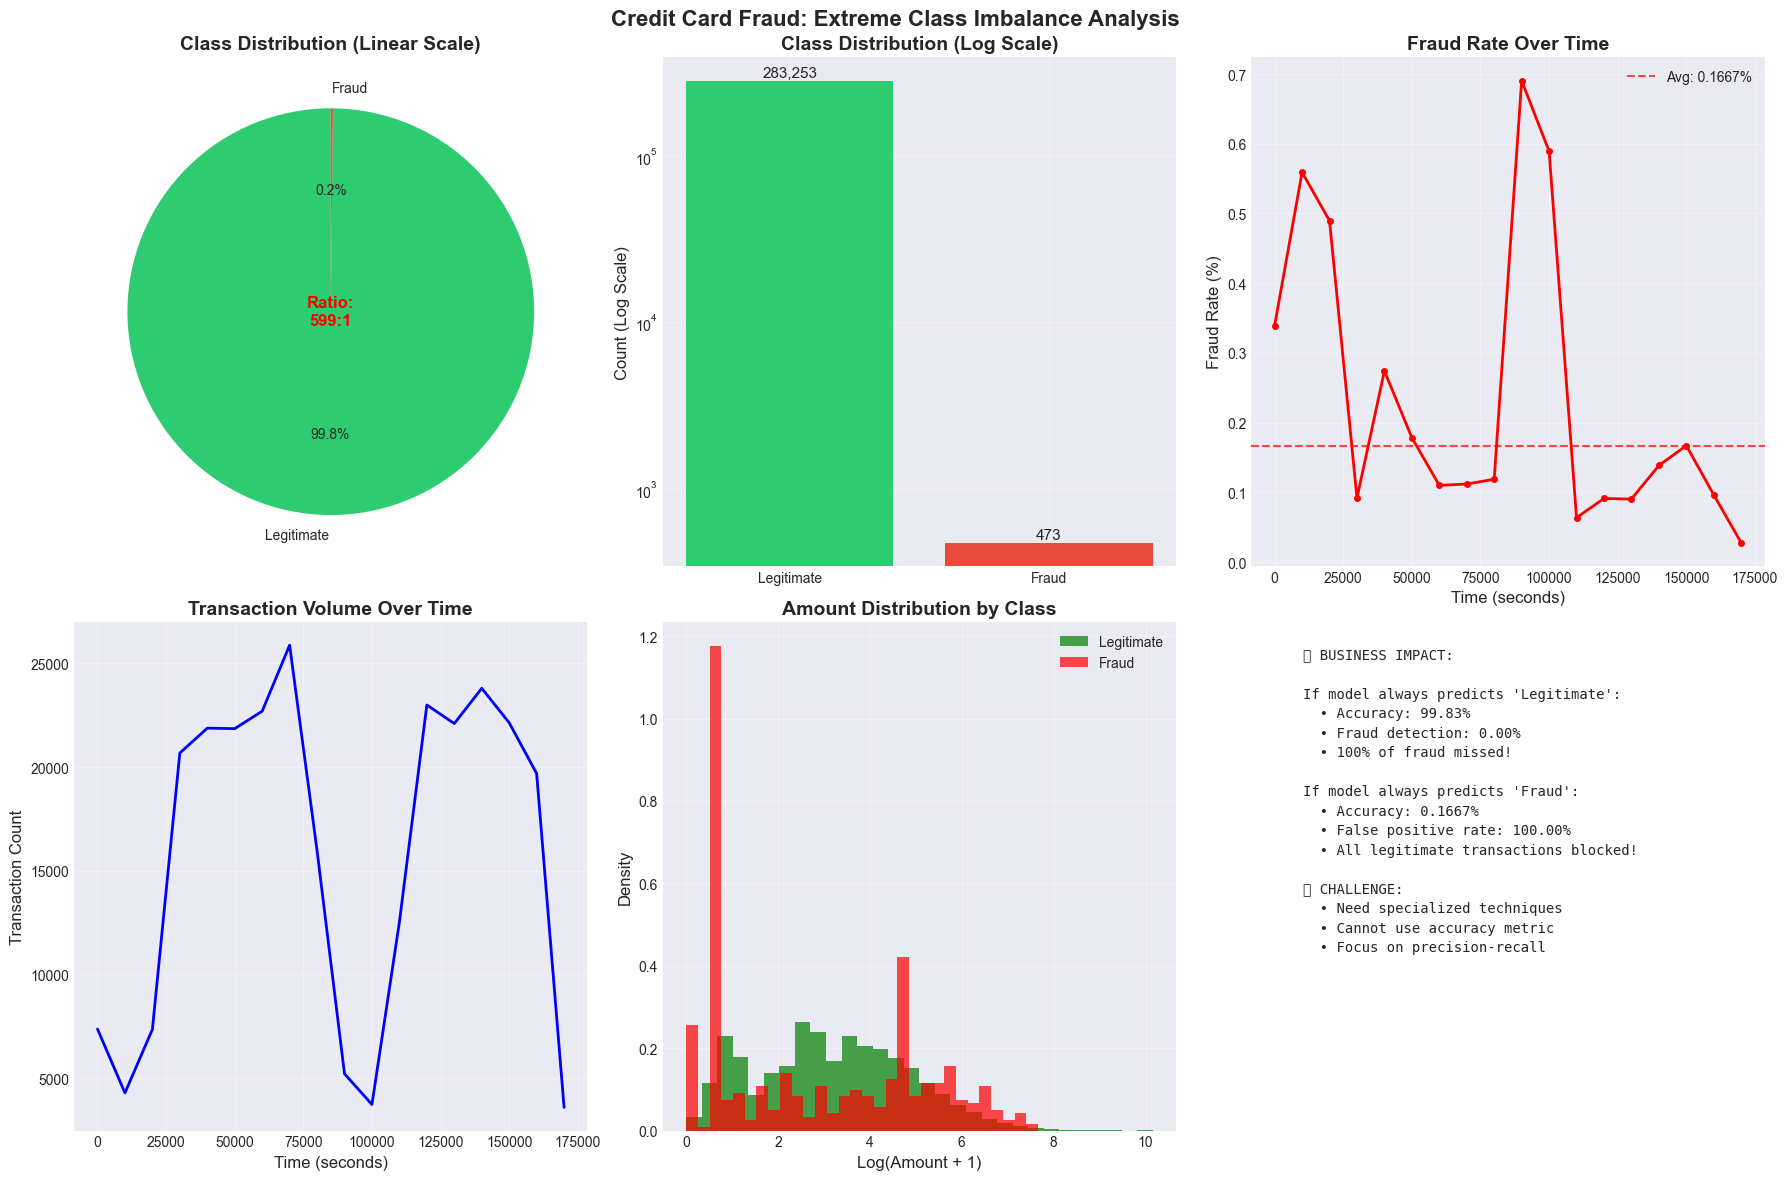


💾 Visualization saved: D:\10 acadamy\fraud-detection-ml-system\outputs\Data_Analysis_processing\visualizations\credit_imbalance_analysis_20251221_095111.png

💸 FINANCIAL IMPACT ANALYSIS:
  • Total fraud loss: $58,591.39
  • Average fraud amount: $123.87
  • Average legitimate amount: $88.41
  • Ratio (fraud/legit): 1.40x


In [3]:
# Class Imbalance Analysis
print("\n" + "="*80)
print("⚠️ EXTREME CLASS IMBALANCE ANALYSIS")
print("="*80)

if credit_df.empty or class_col_found is None:
    print("❌ No data or class column available for analysis")
else:
    # Rename class column to 'Class' for consistency
    if class_col_found != 'Class':
        credit_df = credit_df.rename(columns={class_col_found: 'Class'})
        class_col_found = 'Class'
    
    class_counts = credit_df['Class'].value_counts()
    total_transactions = len(credit_df)
    fraud_transactions = class_counts.get(1, 0)
    legit_transactions = class_counts.get(0, 0)
    fraud_rate = (fraud_transactions / total_transactions) * 100
    imbalance_ratio = legit_transactions / fraud_transactions if fraud_transactions > 0 else float('inf')
    
    print(f"\n📊 BASIC STATISTICS:")
    print(f"  • Total transactions: {total_transactions:,}")
    print(f"  • Legitimate transactions: {legit_transactions:,} ({legit_transactions/total_transactions*100:.2f}%)")
    print(f"  • Fraud transactions: {fraud_transactions:,} ({fraud_rate:.4f}%)")
    print(f"  • Imbalance ratio: {legit_transactions:,}:{fraud_transactions:,} ({imbalance_ratio:,.0f}:1)")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Class Distribution Pie Chart
    ax1 = axes[0, 0]
    colors = ['#2ECC71', '#E74C3C']
    wedges, texts, autotexts = ax1.pie(class_counts.values, labels=['Legitimate', 'Fraud'], 
                                       autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Class Distribution (Linear Scale)', fontsize=14, fontweight='bold')
    # Add imbalance ratio in center
    ax1.text(0, 0, f'Ratio:\n{imbalance_ratio:,.0f}:1', ha='center', va='center', 
             fontsize=12, fontweight='bold', color='red')
    
    # 2. Class Distribution Bar Chart (Log Scale)
    ax2 = axes[0, 1]
    bars = ax2.bar(['Legitimate', 'Fraud'], class_counts.values, color=colors)
    ax2.set_yscale('log')
    ax2.set_ylabel('Count (Log Scale)', fontsize=12)
    ax2.set_title('Class Distribution (Log Scale)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height * 1.01, f'{height:,}', 
                ha='center', va='bottom', fontsize=11)
    
    # 3. Fraud Rate Over Time (if Time column exists)
    ax3 = axes[0, 2]
    if 'Time' in credit_df.columns:
        # Create time bins
        credit_df['time_bin'] = (credit_df['Time'] // 10000) * 10000
        time_stats = credit_df.groupby('time_bin')['Class'].agg(['count', 'sum'])
        time_stats['fraud_rate'] = (time_stats['sum'] / time_stats['count']) * 100
        
        ax3.plot(time_stats.index, time_stats['fraud_rate'], 'r-', linewidth=2, marker='o', markersize=4)
        ax3.axhline(y=fraud_rate, color='red', linestyle='--', alpha=0.7, 
                   label=f'Avg: {fraud_rate:.4f}%')
        ax3.set_xlabel('Time (seconds)', fontsize=12)
        ax3.set_ylabel('Fraud Rate (%)', fontsize=12)
        ax3.set_title('Fraud Rate Over Time', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No Time column available', ha='center', va='center', fontsize=12)
        ax3.set_title('Time Analysis Not Available', fontsize=14, fontweight='bold')
    
    # 4. Transaction Volume Timeline
    ax4 = axes[1, 0]
    if 'Time' in credit_df.columns:
        ax4.plot(time_stats.index, time_stats['count'], 'b-', linewidth=2)
        ax4.set_xlabel('Time (seconds)', fontsize=12)
        ax4.set_ylabel('Transaction Count', fontsize=12)
        ax4.set_title('Transaction Volume Over Time', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No Time column available', ha='center', va='center', fontsize=12)
        ax4.set_title('Volume Analysis Not Available', fontsize=14, fontweight='bold')
    
    # 5. Amount Distribution by Class
    ax5 = axes[1, 1]
    if 'Amount' in credit_df.columns:
        # Take log of amounts for better visualization
        legit_amounts = np.log1p(credit_df[credit_df['Class'] == 0]['Amount'])
        fraud_amounts = np.log1p(credit_df[credit_df['Class'] == 1]['Amount'])
        
        ax5.hist(legit_amounts, bins=30, alpha=0.7, color='green', label='Legitimate', density=True)
        ax5.hist(fraud_amounts, bins=30, alpha=0.7, color='red', label='Fraud', density=True)
        ax5.set_xlabel('Log(Amount + 1)', fontsize=12)
        ax5.set_ylabel('Density', fontsize=12)
        ax5.set_title('Amount Distribution by Class', fontsize=14, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    else:
        ax5.text(0.5, 0.5, 'No Amount column available', ha='center', va='center', fontsize=12)
        ax5.set_title('Amount Analysis Not Available', fontsize=14, fontweight='bold')
    
    # 6. Business Impact Insights
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    insights = []
    insights.append("💡 BUSINESS IMPACT:\n")
    insights.append(f"If model always predicts 'Legitimate':")
    insights.append(f"  • Accuracy: {legit_transactions/total_transactions*100:.2f}%")
    insights.append(f"  • Fraud detection: 0.00%")
    insights.append(f"  • 100% of fraud missed!\n")
    
    insights.append(f"If model always predicts 'Fraud':")
    insights.append(f"  • Accuracy: {fraud_rate:.4f}%")
    insights.append(f"  • False positive rate: 100.00%")
    insights.append(f"  • All legitimate transactions blocked!\n")
    
    insights.append(f"🎯 CHALLENGE:")
    insights.append(f"  • Need specialized techniques")
    insights.append(f"  • Cannot use accuracy metric")
    insights.append(f"  • Focus on precision-recall")
    
    ax6.text(0.1, 0.95, '\n'.join(insights), fontsize=10, 
             verticalalignment='top', fontfamily='monospace', linespacing=1.5)
    
    plt.suptitle('Credit Card Fraud: Extreme Class Imbalance Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # Save visualization
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    imbalance_file = VISUALIZATIONS_DIR / f"credit_imbalance_analysis_{timestamp}.png"
    plt.savefig(imbalance_file, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Visualization saved: {imbalance_file}")
    
    # Detailed statistics
    print(f"\n💸 FINANCIAL IMPACT ANALYSIS:")
    if 'Amount' in credit_df.columns:
        total_fraud_loss = credit_df[credit_df['Class'] == 1]['Amount'].sum()
        avg_fraud_amount = credit_df[credit_df['Class'] == 1]['Amount'].mean()
        avg_legit_amount = credit_df[credit_df['Class'] == 0]['Amount'].mean()
        
        print(f"  • Total fraud loss: ${total_fraud_loss:,.2f}")
        print(f"  • Average fraud amount: ${avg_fraud_amount:.2f}")
        print(f"  • Average legitimate amount: ${avg_legit_amount:.2f}")
        print(f"  • Ratio (fraud/legit): {avg_fraud_amount/avg_legit_amount:.2f}x")

Transaction Amount Analysis

Key Question: Do fraud transactions have different amount patterns?

Analysis Steps:
1. Compare amount distributions for fraud vs legitimate
2. Analyze fraud rates by amount ranges
3. Calculate cumulative fraud loss
4. Identify high-risk amount thresholds

Expected Insights:
- Fraud amounts may be larger/smaller than legitimate
- Certain amount ranges may have higher fraud rates
- Financial impact of fraud


💰 TRANSACTION AMOUNT ANALYSIS

📊 AMOUNT STATISTICS:
  • Overall mean: $88.47
  • Overall median: $22.00
  • Fraud mean: $123.87
  • Legitimate mean: $88.41
  • Ratio (fraud/legit): 1.40x
  • Total fraud loss: $58,591.39


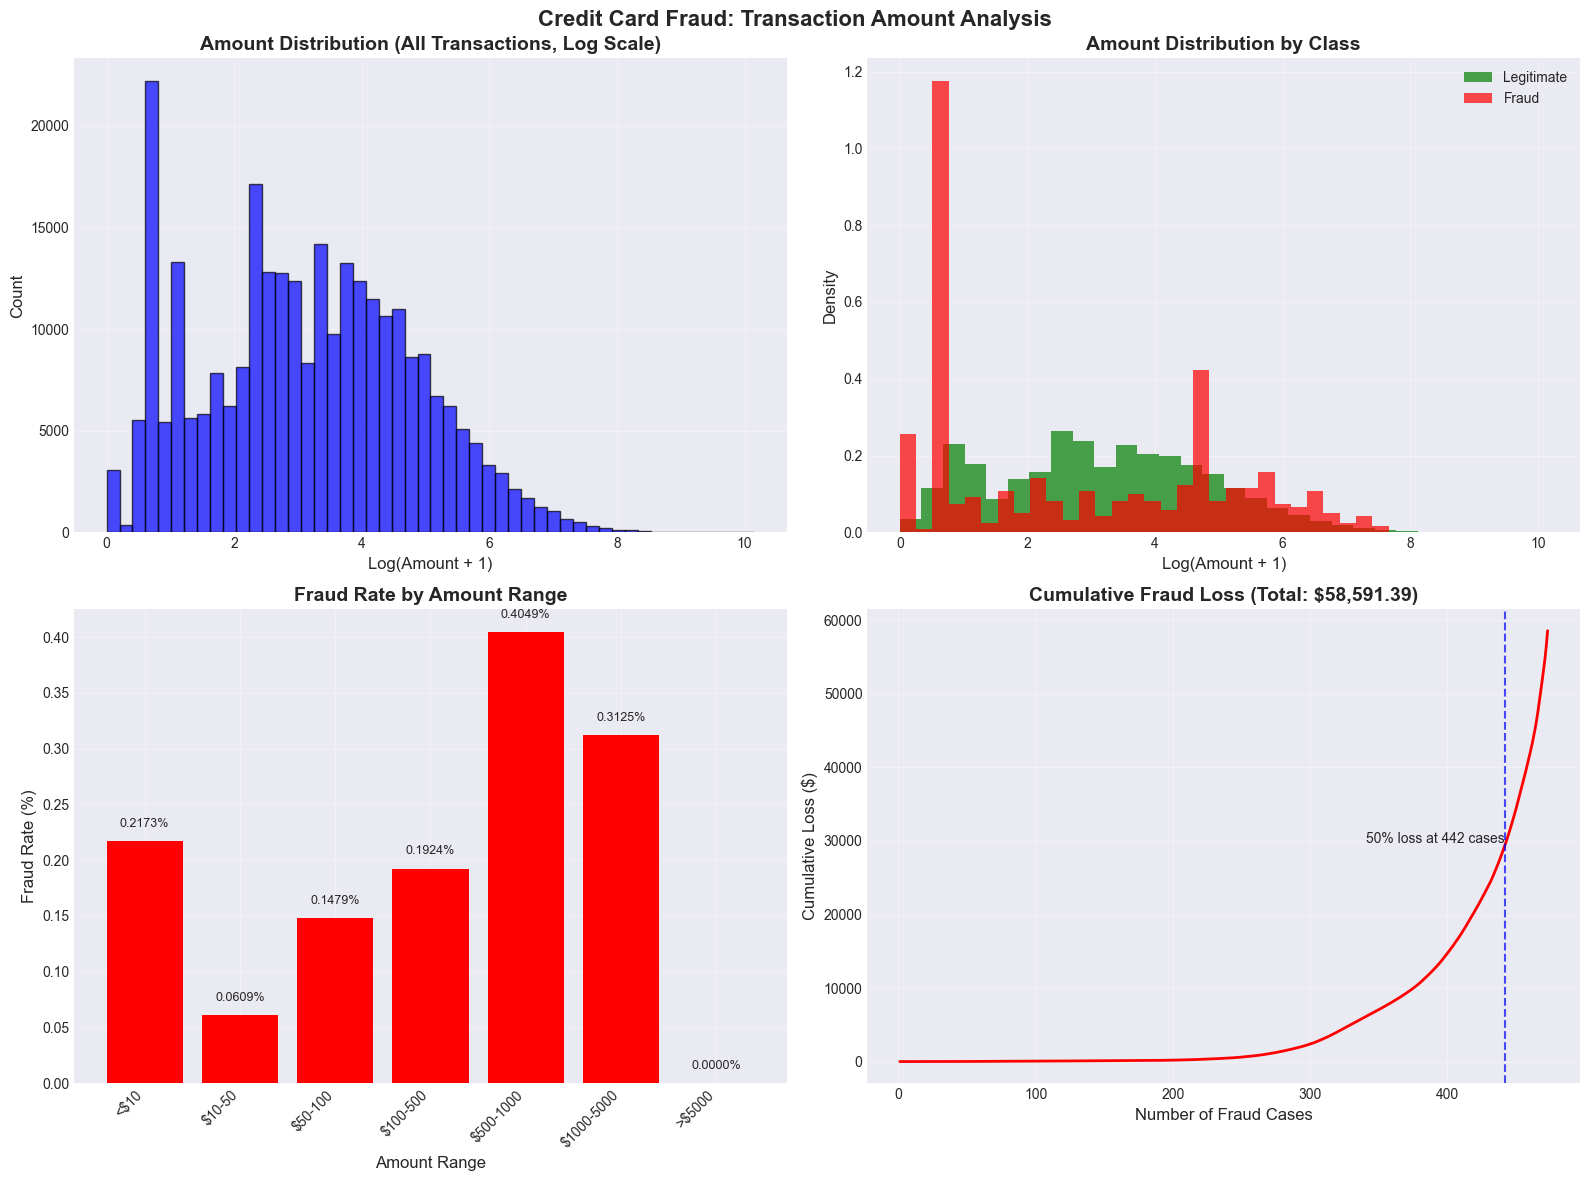


💾 Visualization saved: D:\10 acadamy\fraud-detection-ml-system\outputs\Data_Analysis_processing\visualizations\credit_amount_analysis_20251221_095111.png

🎯 HIGH-RISK AMOUNT RANGES:
  • $500-1000: 0.4049% fraud rate
    (25.0 fraud cases)


In [4]:
# Transaction Amount Analysis
print("\n" + "="*80)
print("💰 TRANSACTION AMOUNT ANALYSIS")
print("="*80)

if credit_df.empty or 'Amount' not in credit_df.columns or 'Class' not in credit_df.columns:
    print("❌ Required data not available for amount analysis")
else:
    # Calculate amount statistics
    amount_stats_overall = credit_df['Amount'].describe()
    fraud_amount_stats = credit_df[credit_df['Class'] == 1]['Amount'].describe()
    legit_amount_stats = credit_df[credit_df['Class'] == 0]['Amount'].describe()
    
    total_fraud_loss = credit_df[credit_df['Class'] == 1]['Amount'].sum()
    
    print(f"\n📊 AMOUNT STATISTICS:")
    print(f"  • Overall mean: ${amount_stats_overall['mean']:.2f}")
    print(f"  • Overall median: ${amount_stats_overall['50%']:.2f}")
    print(f"  • Fraud mean: ${fraud_amount_stats['mean']:.2f}")
    print(f"  • Legitimate mean: ${legit_amount_stats['mean']:.2f}")
    print(f"  • Ratio (fraud/legit): {fraud_amount_stats['mean']/legit_amount_stats['mean']:.2f}x")
    print(f"  • Total fraud loss: ${total_fraud_loss:,.2f}")
    
    # Create amount analysis visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Amount Distribution - All Transactions
    ax1 = axes[0, 0]
    ax1.hist(np.log1p(credit_df['Amount']), bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax1.set_xlabel('Log(Amount + 1)', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Amount Distribution (All Transactions, Log Scale)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. Amount Distribution by Class
    ax2 = axes[0, 1]
    ax2.hist(np.log1p(credit_df[credit_df['Class'] == 0]['Amount']), bins=30, alpha=0.7, 
             color='green', label='Legitimate', density=True)
    ax2.hist(np.log1p(credit_df[credit_df['Class'] == 1]['Amount']), bins=30, alpha=0.7, 
             color='red', label='Fraud', density=True)
    ax2.set_xlabel('Log(Amount + 1)', fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.set_title('Amount Distribution by Class', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Fraud Rate by Amount Range
    ax3 = axes[1, 0]
    # Create amount bins
    amount_bins = [0, 10, 50, 100, 500, 1000, 5000, float('inf')]
    amount_labels = ['<$10', '$10-50', '$50-100', '$100-500', 
                     '$500-1000', '$1000-5000', '>$5000']
    
    credit_df['amount_range'] = pd.cut(credit_df['Amount'], 
                                      bins=amount_bins, 
                                      labels=amount_labels)
    
    amount_stats = credit_df.groupby('amount_range')['Class'].agg(['count', 'sum'])
    amount_stats['fraud_rate'] = (amount_stats['sum'] / amount_stats['count']) * 100
    
    bars = ax3.bar(amount_stats.index, amount_stats['fraud_rate'], color='red')
    ax3.set_xlabel('Amount Range', fontsize=12)
    ax3.set_ylabel('Fraud Rate (%)', fontsize=12)
    ax3.set_title('Fraud Rate by Amount Range', fontsize=14, fontweight='bold')
    ax3.set_xticklabels(amount_stats.index, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f}%', 
                ha='center', va='bottom', fontsize=9)
    
    # 4. Cumulative Fraud Loss
    ax4 = axes[1, 1]
    fraud_df_sorted = credit_df[credit_df['Class'] == 1].sort_values('Amount')
    fraud_df_sorted['cumulative_loss'] = fraud_df_sorted['Amount'].cumsum()
    fraud_df_sorted['cumulative_count'] = range(1, len(fraud_df_sorted) + 1)
    
    ax4.plot(fraud_df_sorted['cumulative_count'], fraud_df_sorted['cumulative_loss'], 
            'r-', linewidth=2)
    ax4.set_xlabel('Number of Fraud Cases', fontsize=12)
    ax4.set_ylabel('Cumulative Loss ($)', fontsize=12)
    ax4.set_title(f'Cumulative Fraud Loss (Total: ${total_fraud_loss:,.2f})', 
                  fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add annotations
    if len(fraud_df_sorted) > 0:
        # Mark where 50% of loss occurs
        half_loss = total_fraud_loss / 2
        if fraud_df_sorted['cumulative_loss'].max() >= half_loss:
            idx = (fraud_df_sorted['cumulative_loss'] >= half_loss).idxmax()
            half_count = fraud_df_sorted.loc[idx, 'cumulative_count']
            ax4.axvline(x=half_count, color='blue', linestyle='--', alpha=0.7)
            ax4.text(half_count, half_loss, f'50% loss at {half_count} cases', 
                    ha='right', va='bottom', fontsize=10)
    
    plt.suptitle('Credit Card Fraud: Transaction Amount Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # Save visualization
    amount_file = VISUALIZATIONS_DIR / f"credit_amount_analysis_{timestamp}.png"
    plt.savefig(amount_file, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Visualization saved: {amount_file}")
    
    # High-risk amount ranges
    print(f"\n🎯 HIGH-RISK AMOUNT RANGES:")
    avg_fraud_rate = (credit_df['Class'].sum() / len(credit_df)) * 100
    for amount_range, stats in amount_stats.iterrows():
        if stats['fraud_rate'] > avg_fraud_rate * 2:  # More than 2x average
            print(f"  • {amount_range}: {stats['fraud_rate']:.4f}% fraud rate")
            print(f"    ({stats['sum']:,} fraud cases)")


🔍 V FEATURE ANALYSIS (PCA COMPONENTS)

📊 Found 28 V features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

📈 TOP 5 MOST CORRELATED V FEATURES:
  1. V17: correlation = 0.3135
  2. V14: correlation = 0.2934
  3. V12: correlation = 0.2507
  4. V10: correlation = 0.2070
  5. V16: correlation = 0.1872

📉 BOTTOM 5 LEAST CORRELATED V FEATURES:
  1. V22: correlation = 0.004887
  2. V26: correlation = 0.004265
  3. V13: correlation = 0.003897
  4. V15: correlation = 0.003300
  5. V25: correlation = 0.003202


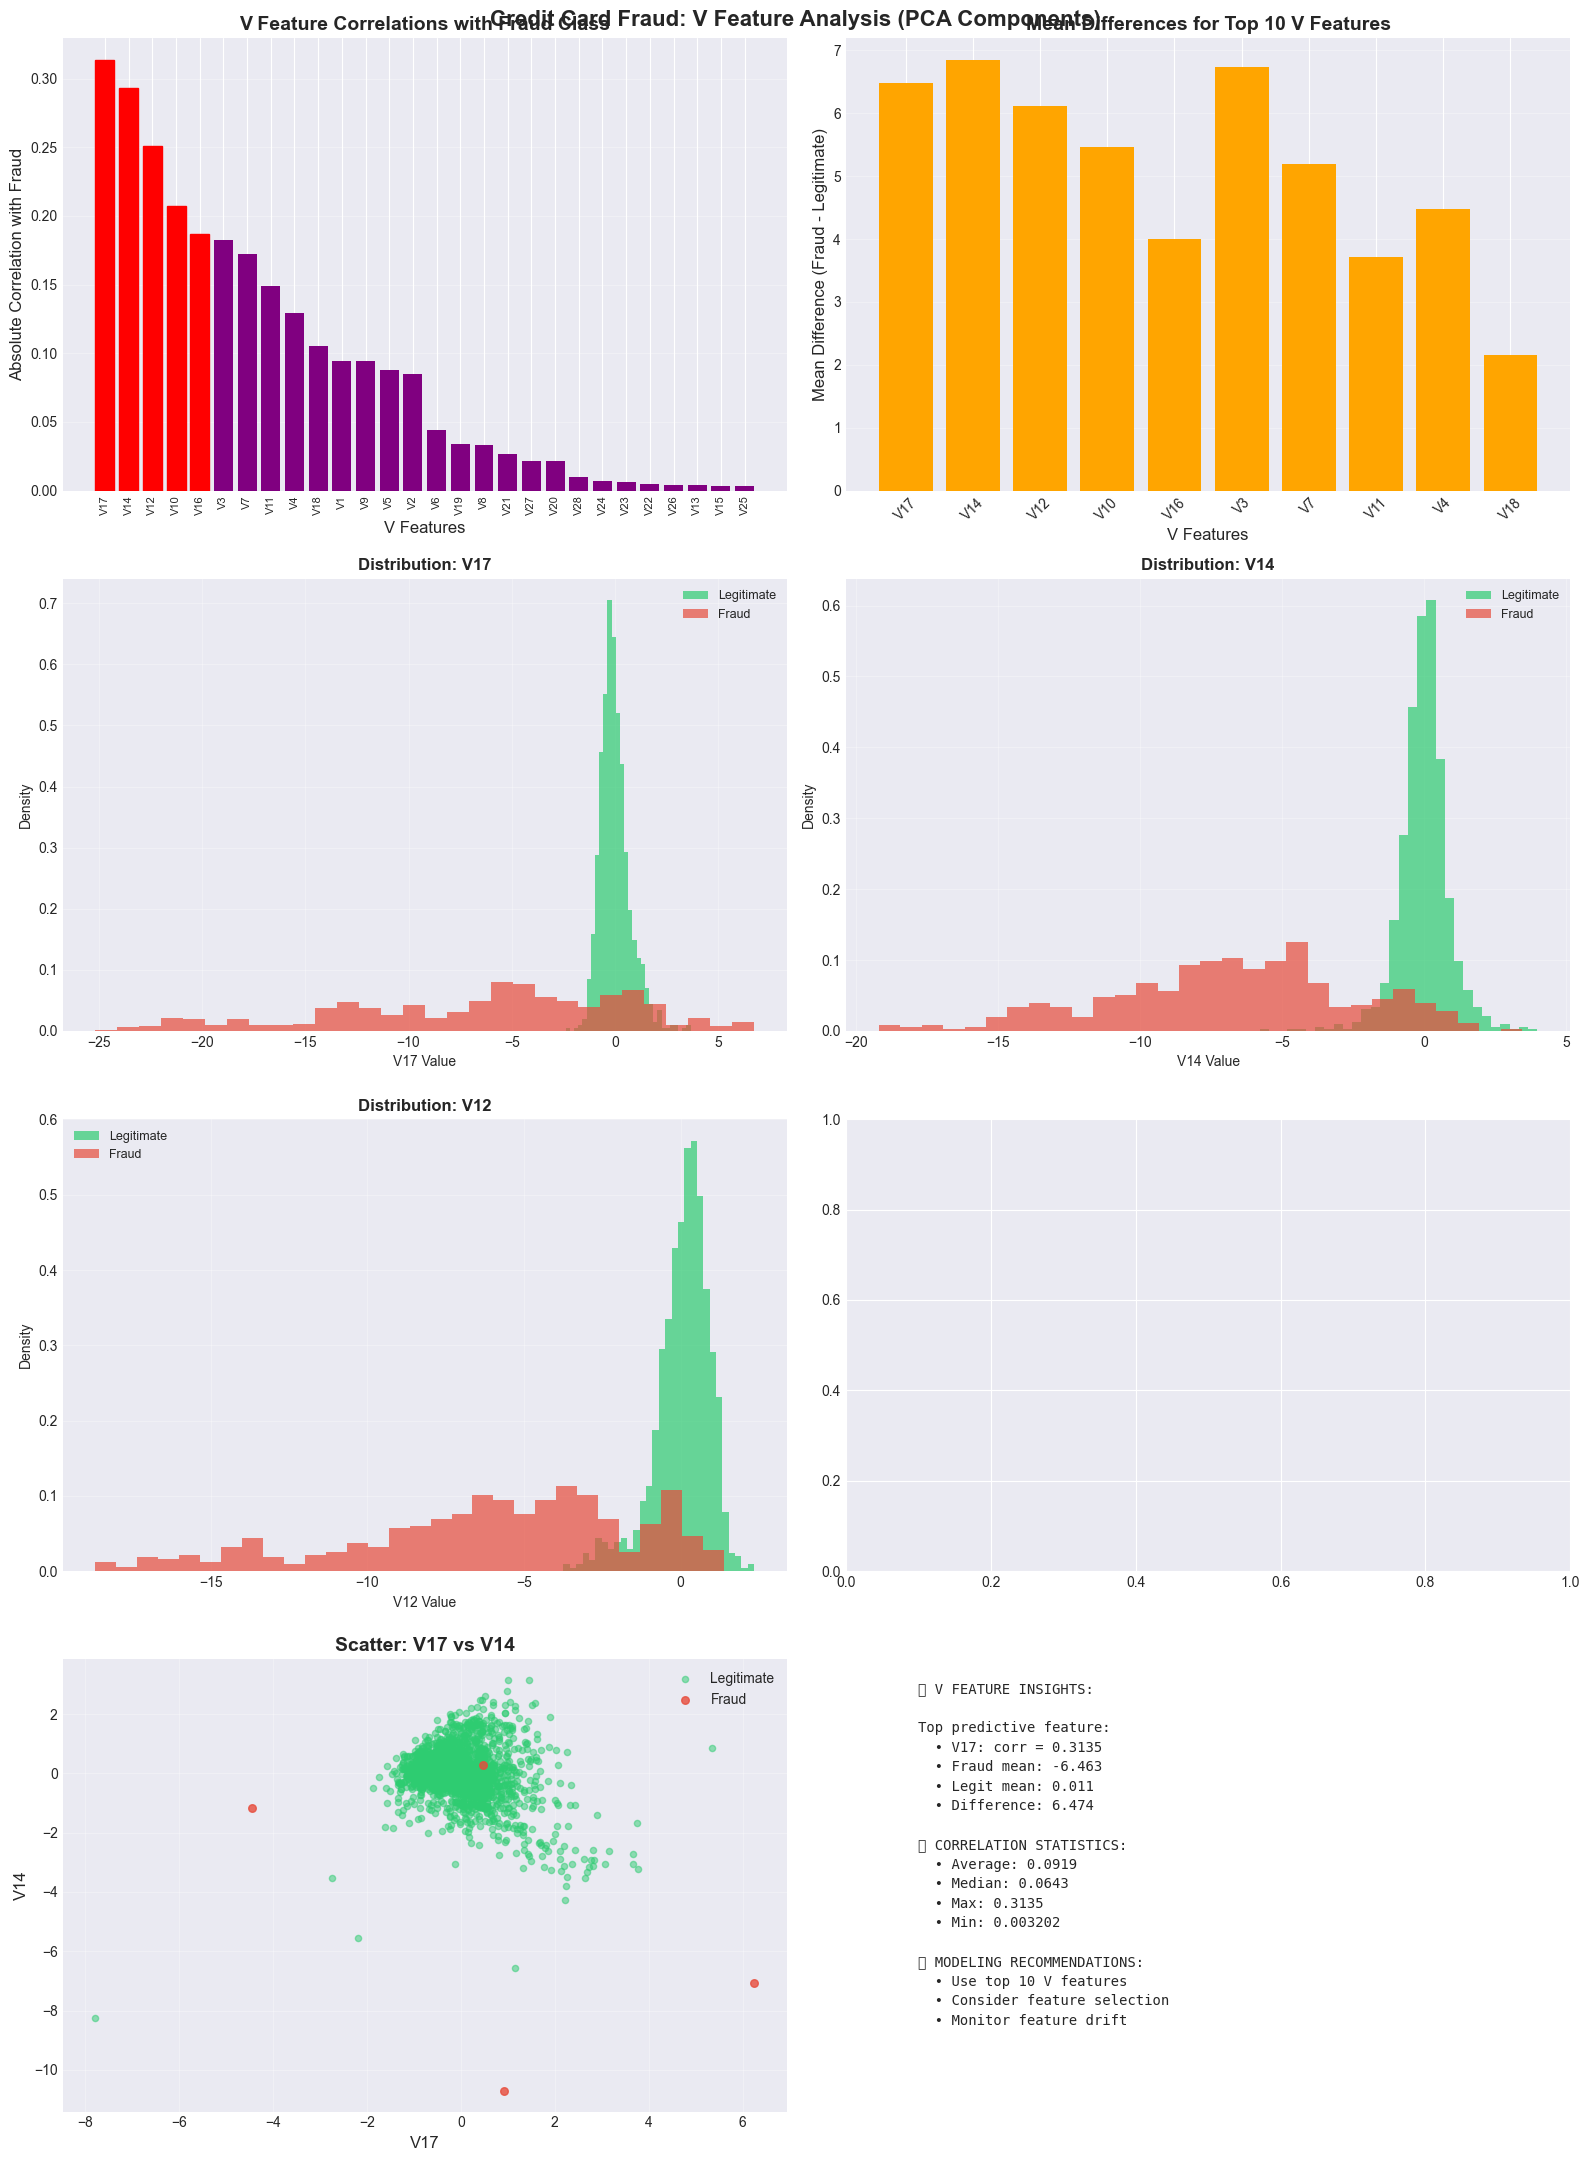


💾 Visualization saved: D:\10 acadamy\fraud-detection-ml-system\outputs\Data_Analysis_processing\visualizations\credit_v_features_analysis_20251221_095131.png
💾 V feature correlations saved: D:\10 acadamy\fraud-detection-ml-system\outputs\Data_Analysis_processing\statistics\credit_v_features_correlations_20251221_095131.csv


In [5]:
# ============================================================================
# V FEATURE ANALYSIS WITH FIXED TIMESTAMP
# ============================================================================

# Add this import if not already at the top
from datetime import datetime

print("\n" + "="*80)
print("🔍 V FEATURE ANALYSIS (PCA COMPONENTS)")
print("="*80)

# Create timestamp for filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Identify V features
v_columns = [col for col in credit_df.columns if col.startswith('V')]
print(f"\n📊 Found {len(v_columns)} V features: {v_columns}")

if len(v_columns) == 0:
    print("❌ No V features found in the dataset")
else:
    # Calculate correlations with Class
    v_correlations = {}
    for v_col in v_columns:
        correlation = credit_df[v_col].corr(credit_df['Class'])
        v_correlations[v_col] = abs(correlation)
    
    # Sort by correlation
    sorted_v = sorted(v_correlations.items(), key=lambda x: x[1], reverse=True)
    top_5_v = sorted_v[:5]
    bottom_5_v = sorted_v[-5:]
    
    print(f"\n📈 TOP 5 MOST CORRELATED V FEATURES:")
    for i, (v_feature, correlation) in enumerate(top_5_v, 1):
        print(f"  {i}. {v_feature}: correlation = {correlation:.4f}")
    
    print(f"\n📉 BOTTOM 5 LEAST CORRELATED V FEATURES:")
    for i, (v_feature, correlation) in enumerate(bottom_5_v, 1):
        print(f"  {i}. {v_feature}: correlation = {correlation:.6f}")
    
    # Calculate mean differences
    v_means_fraud = credit_df[credit_df['Class'] == 1][v_columns].mean()
    v_means_legit = credit_df[credit_df['Class'] == 0][v_columns].mean()
    
    # Create V feature analysis visualizations
    # Changed to (4, 2) grid to accommodate all plots
    fig, axes = plt.subplots(4, 2, figsize=(16, 22))
    
    # 1. V Feature Correlations with Fraud
    ax1 = axes[0, 0]
    correlations = [v[1] for v in sorted_v]
    v_names = [v[0] for v in sorted_v]
    
    bars = ax1.bar(range(len(correlations)), correlations, color='purple')
    ax1.set_xlabel('V Features', fontsize=12)
    ax1.set_ylabel('Absolute Correlation with Fraud', fontsize=12)
    ax1.set_title('V Feature Correlations with Fraud Class', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(correlations)))
    ax1.set_xticklabels(v_names, rotation=90, fontsize=8)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Highlight top 5
    for i in range(5):
        bars[i].set_color('red')
    
    # 2. Mean Differences by Class (Top 10)
    ax2 = axes[0, 1]
    top_10_features = [v[0] for v in sorted_v[:10]]
    mean_diffs = abs(v_means_fraud[top_10_features] - v_means_legit[top_10_features])
    
    bars = ax2.bar(range(len(mean_diffs)), mean_diffs.values, color='orange')
    ax2.set_xlabel('V Features', fontsize=12)
    ax2.set_ylabel('Mean Difference (Fraud - Legitimate)', fontsize=12)
    ax2.set_title('Mean Differences for Top 10 V Features', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(mean_diffs)))
    ax2.set_xticklabels(mean_diffs.index, rotation=45, fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Distribution of Top 3 V Features
    colors = ['#2ECC71', '#E74C3C']
    for i, (v_feature, _) in enumerate(top_5_v[:3]):
        # Calculate row and column positions for (4, 2) grid
        row = 1 + i // 2  # Row 1: i=0,1; Row 2: i=2
        col = i % 2       # Column alternates 0,1,0
        
        ax = axes[row, col]
        
        # Sample data for visualization
        legit_sample = credit_df[credit_df['Class'] == 0][v_feature].sample(min(1000, len(credit_df[credit_df['Class'] == 0])))
        fraud_data = credit_df[credit_df['Class'] == 1][v_feature]
        
        ax.hist(legit_sample, bins=30, alpha=0.7, color=colors[0], label='Legitimate', density=True)
        ax.hist(fraud_data, bins=30, alpha=0.7, color=colors[1], label='Fraud', density=True)
        ax.set_xlabel(f'{v_feature} Value', fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        ax.set_title(f'Distribution: {v_feature}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    # 4. Scatter plot of Top 2 V Features
    ax6 = axes[3, 0]  # Moved to row 3, column 0
    if len(top_5_v) >= 2:
        top_v1, top_v2 = top_5_v[0][0], top_5_v[1][0]
        
        # Sample for visualization
        sample_size = min(2000, len(credit_df))
        sample_data = credit_df.sample(sample_size)
        
        legit_data = sample_data[sample_data['Class'] == 0]
        fraud_data = sample_data[sample_data['Class'] == 1]
        
        ax6.scatter(legit_data[top_v1], legit_data[top_v2], 
                   alpha=0.5, s=20, color=colors[0], label='Legitimate')
        ax6.scatter(fraud_data[top_v1], fraud_data[top_v2], 
                   alpha=0.8, s=30, color=colors[1], label='Fraud')
        
        ax6.set_xlabel(top_v1, fontsize=12)
        ax6.set_ylabel(top_v2, fontsize=12)
        ax6.set_title(f'Scatter: {top_v1} vs {top_v2}', fontsize=14, fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'Insufficient V features\nfor scatter plot', 
                ha='center', va='center', fontsize=12)
        ax6.set_title('Scatter Plot Not Available', fontsize=14, fontweight='bold')
    
    # 5. Insights and Recommendations
    ax7 = axes[3, 1]  # Moved to row 3, column 1
    ax7.axis('off')
    
    insights = []
    insights.append("📊 V FEATURE INSIGHTS:\n")
    
    # Top feature insights
    if top_5_v:
        top_feature, top_corr = top_5_v[0]
        insights.append(f"Top predictive feature:")
        insights.append(f"  • {top_feature}: corr = {top_corr:.4f}")
        insights.append(f"  • Fraud mean: {v_means_fraud[top_feature]:.3f}")
        insights.append(f"  • Legit mean: {v_means_legit[top_feature]:.3f}")
        insights.append(f"  • Difference: {abs(v_means_fraud[top_feature] - v_means_legit[top_feature]):.3f}\n")
    
    insights.append(f"📈 CORRELATION STATISTICS:")
    insights.append(f"  • Average: {np.mean(list(v_correlations.values())):.4f}")
    insights.append(f"  • Median: {np.median(list(v_correlations.values())):.4f}")
    insights.append(f"  • Max: {max(v_correlations.values()):.4f}")
    insights.append(f"  • Min: {min(v_correlations.values()):.6f}\n")
    
    insights.append(f"🎯 MODELING RECOMMENDATIONS:")
    insights.append(f"  • Use top {min(10, len(v_columns))} V features")
    insights.append(f"  • Consider feature selection")
    insights.append(f"  • Monitor feature drift")
    
    ax7.text(0.1, 0.95, '\n'.join(insights), fontsize=10, 
             verticalalignment='top', fontfamily='monospace', linespacing=1.5)
    
    plt.suptitle('Credit Card Fraud: V Feature Analysis (PCA Components)', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    # Save visualization - FIXED PATH HANDLING
    try:
        # Ensure VISUALIZATIONS_DIR is a Path object
        if hasattr(VISUALIZATIONS_DIR, 'joinpath') or isinstance(VISUALIZATIONS_DIR, Path):
            v_features_file = VISUALIZATIONS_DIR / f"credit_v_features_analysis_{timestamp}.png"
        else:
            from pathlib import Path
            vis_dir = Path(VISUALIZATIONS_DIR)
            v_features_file = vis_dir / f"credit_v_features_analysis_{timestamp}.png"
    except Exception as e:
        print(f"⚠️ Path error: {e}. Using string concatenation.")
        v_features_file = f"{VISUALIZATIONS_DIR}/credit_v_features_analysis_{timestamp}.png"
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(str(v_features_file)), exist_ok=True)
    
    plt.savefig(str(v_features_file), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Visualization saved: {v_features_file}")
    
    # Save V feature correlations
    v_corr_df = pd.DataFrame({
        'V_Feature': list(v_correlations.keys()),
        'Correlation_with_Fraud': list(v_correlations.values()),
        'Fraud_Mean': [v_means_fraud.get(v, 0) for v in v_correlations.keys()],
        'Legit_Mean': [v_means_legit.get(v, 0) for v in v_correlations.keys()],
        'Mean_Difference': [abs(v_means_fraud.get(v, 0) - v_means_legit.get(v, 0)) for v in v_correlations.keys()]
    }).sort_values('Correlation_with_Fraud', ascending=False)
    
    # Save to CSV - FIXED PATH HANDLING
    try:
        if hasattr(STATISTICS_DIR, 'joinpath') or isinstance(STATISTICS_DIR, Path):
            v_corr_file = STATISTICS_DIR / f"credit_v_features_correlations_{timestamp}.csv"
        else:
            from pathlib import Path
            stat_dir = Path(STATISTICS_DIR)
            v_corr_file = stat_dir / f"credit_v_features_correlations_{timestamp}.csv"
    except Exception as e:
        print(f"⚠️ Path error: {e}. Using string concatenation.")
        v_corr_file = f"{STATISTICS_DIR}/credit_v_features_correlations_{timestamp}.csv"
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(str(v_corr_file)), exist_ok=True)
    
    v_corr_df.to_csv(str(v_corr_file), index=False)
    print(f"💾 V feature correlations saved: {v_corr_file}")